<!-- PELICAN_BEGIN_SUMMARY -->

This notebook aims to provide a basic example of how to run a variety of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) and [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) codes in [Python](https://www.python.org/). It won't go into detail about MCMC methods in general, and assumes a bit of knowledge about them, nor will it discuss all the various bells-and-whistles that each sampler can use, but it will hopefully help people get started with writing a sampler code using an understandable (albeit "toy") example. A very nice, quite similar, article on this topic by [Jake VanderPlas](http://vanderplas.com/) can be found [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). There are also very good [online notes](http://people.duke.edu/~ccc14/sta-663-2017/20A_MCMC.html) from the _Computational Statistics and Statistical Computing_ course at [Duke University](https://www.duke.edu/) by [Cliburn Chan](https://genome.duke.edu/directory/cbb-faculty/cliburn-chan-phd) & [Janice McCarthy](https://scholars.duke.edu/person/janice.mccarthy), covering some of this material (including [PyMC3](http://people.duke.edu/~ccc14/sta-663-2017/19A_PyMC3.html) and [PyStan](http://people.duke.edu/~ccc14/sta-663-2017/19B_Pystan.html#estimating-parameters-of-a-linear-regression-model) examples that are very similar to what is covered here). Section 2 of [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757) gives a nice summary of the advantages and disadvantages of some of the algorithms shown here.

<!-- PELICAN_END_SUMMARY -->

You can jump straight to the examples for the different samplers with the links below:

[**MCMC samplers**](#MCMC-samplers):
  1. [emcee](#emcee)
  2. [PyMC3](#PyMC3)
  3. [PyStan](#PyStan)
  4. [PyJAGS](#PyJAGS)

[**Nested samplers**](#Nested-Sampling):
  1. [Nestle](#Nestle)
  2. [CPNest](#CPNest)
  3. [PyMultiNest](#PyMultiNest)
  4. [DNest4](#DNest4)
  5. [PyPolyChord](#PyPolyChord)

## Background

MCMC methods are most often used in the context of Bayesian parameter estimation, e.g., you have a model, $y$, defined by a set of unknown parameters, ${\vec{\theta}}$, with certain prior probability distributions $p(\vec{\theta}|I)$, and you want to sample from the marginalised posterior probability distributions on those parameters given some data, $\mathbf{d}$, and a particular [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function), $p(\mathbf{d}|\vec{\theta},I)$, ($I$ is just a substitute for all the implicit assumptions that have gone into defining our model). From Bayes theorem we have the joint posterior on the whole set of parameters,

$$
p(\vec{\theta}|\mathbf{d},I) = \frac{p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I)}{p(\mathbf{d}|I)},
$$

with marginalised posteriors on an individual parameter, say $\theta_1$, given by nested integrals over all other parameters,

$$
p(\theta_1|\mathbf{d},I) = \frac{1}{p(\mathbf{d}|I)}\int^{\forall \theta_i \in (\vec{\theta}\neq \theta_1)} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

($\forall \theta_i \in (\vec{\theta}\neq \theta_1)$ can be translated into "for all parameters $\theta_i$ in $\vec{\theta}$ that are not equal to $\theta_1$). $p(\mathbf{d}|I)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood), or _evidence_, for the data, and is given by

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

which will be discussed below in relation to [nested sampling](#Nested-Sampling).

This is the only context I (and probably many people in the physical sciences) have encountered using MCMC methods, and is the context I will use below.

## Toy model

The very basic example that I will use to demonstrate coding up the samplers is that of sampling from the posteriors of two parameters, $m$ and $c$, defining the model:

$$
y(\mathbf{x};m,c) = m\mathbf{x} + c,
$$

where $\mathbf{x}$ is a vector of values of $x$. This is basically fitting the gradient and $y$-intercept of a straight line, which should be fairly familiar as [linear regression](https://en.wikipedia.org/wiki/Linear_regression), and is obviously a solved problem (_assuming uniform priors!_) using, e.g., [least squares fitting](https://en.wikipedia.org/wiki/Linear_least_squares_%29mathematics%29). But, this provides a simple example that can hopefully be extended to more realistics scenarios.

Our aim is to produce samples drawn from the marginalised posteriors $p(m|\mathbf{d},I)$, and $p(c|\mathbf{d},I)$.

The vector of data samples, $\mathbf{d}$, will consist of the model defined at a set of $M$ values, $\mathbf{x}$, with additive Gaussian noise of known standard deviation, i.e., data point $i$ will be defined by

$$
d_i = y(x_i;m,c) + n_i,
$$

with

$$
n_i \sim N(0, \sigma_i),
$$

which means the noise is drawn from a [Gaussian (or Normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution) of zero mean and standard deviation of $\sigma_i$.

> _Note_: _I'll generally use the term [Gaussian distribution](https://en.wikipedia.org/wiki/Normal%5fdistribution)
> rather than "Normal" distribution, as this it what I first heard it called. But, in many packages discussed below
> "Normal" is the more common word for the distribution._

### Setting the likelihood

Given the above choice of noise, a sensible (and fairly standard) likelihood function for a data point given values of $m$ and $c$, will be given by a Gaussian distribution of the form

$$
p(d_i|m,c,I) = \left(2\pi\sigma_i^2\right)^{-1/2} \exp{\left(-\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)},
$$

and the joint likelihood for the whole dataset of $M$ points (assuming independent noise) will be the product of the individual likelihoods

$$
p(\mathbf{d}|m,c,I) = \prod_{i=1}^M p(d_i|m,c,I) = \left(2\pi\right)^{-M/2}\left(\prod_{i=1}^M \sigma_i^{-1} \right) \exp{\left(-\sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)}
$$

When computing likelihoods, numerical considerations mean that one almost always works with the natural logarithm of the likelihood, so we have

$$
\ln{p(\mathbf{d}|m,c,I)} \equiv \log{L} = -\frac{M}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^M \sigma_i\right) - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}
$$

For many cases we can ignore the terms that do not include our required parameters when sampling from their marginalised likelihoods (as they will just be constants), so often the log-likelihood can be set to be

$$
\log{L} = - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}.
$$

> _Note_: _If wanting to evaluate the marginal likelihood for the data (e.g., using nested sampling, which is
> discussed later) to use it for [model comparison](https://en.wikipedia.org/wiki/Bayes%5ffactor), the constants 
> are required._

### Setting the prior

In addition to the likelihood, we need to define [priors](https://en.wikipedia.org/wiki/Prior_probability) on the parameters. To demonstrate a couple of different, and reasonably common, priors, I'll use a uniform probability distribution for the prior on $m$ and a Gaussian probability distribution for the prior on $c$:

$$
p(m|\mu_m,\sigma_m,I) = \frac{1}{\sqrt{2\pi\sigma_m^2}}\exp{\left(-\frac{(m-\mu_m)^2}{2\sigma_m^2}\right)},
$$

and

$$
p(c|c_{\rm min}, c_{\rm max}) = \frac{1}{c_{\rm max}-c_{\rm min}}.
$$

In our example we'll set:

 * $\mu_m = 0$ and $\sigma_m = 10$,
 * $c_{\rm min} = -10$ and $c_{\rm max} = -10$.
 
> _Note_: _These priors are not intended to be the [least informative](https://en.wikipedia.org/wiki/Prior%5fprobability#Uninformative%5fpriors) for the parameterisation that we have, but
> are just chosen for demonstration purposes to show how to code up two different distributions. A better prior
> for this particular problem might be the one discussed [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#The-Prior), which 
> could be coded up for PyMC3 using the example [here](http://docs.pymc.io/notebooks/getting%5fstarted.html#Arbitrary-distributions)._

### Creating the data

So, let's get started creating our data. I'll (arbitrarily) use:

 * $m = 3.5$,
 * $c = 1.2$,

for the model and

 * $\mathbf{x} \in [0, 10)$ in $M=100$ uniform steps ($[a,b)$ means [inclusive of $a$, but exclusive of $b$](https://en.wikipedia.org/wiki/Bracket_%28mathematics%29#Intervals)),
 * $\sigma_i = \sigma = 0.5$ (i.e., each noise point is independent, but has the same standard deviation),
 
for the data.

In [1]:
# show plots inline in the notebook
%matplotlib inline

from __future__ import division, print_function # python3 compatibilty

import numpy as np                  # import numpy
from time import time               # use for timing functions

# useful modules!
import sys
import os
import six

# make the plots look a bit nicer with some defaults
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.sans-serif'] = 'Avant Garde, Helvetica, Computer Modern Sans serif'
rcparams['font.size'] = 22

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

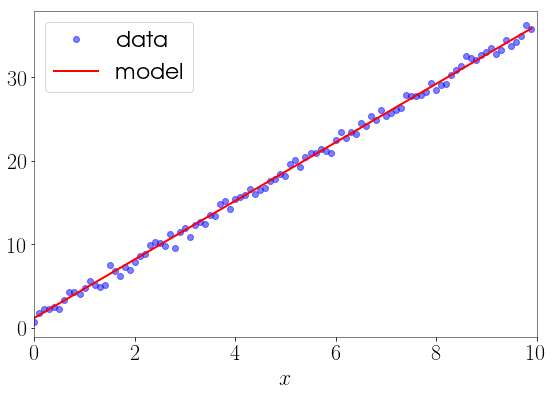

In [2]:
# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

## MCMC samplers

First up I'll deal with MCMC samplers that are purely written in Python, then a couple that are wrappers to other libraries.

### emcee

[emcee](http://dfm.io/emcee/current/) ([Foreman-Mackey _et al_, 2013](https://arxiv.org/abs/1202.3665)) is a Python MCMC implementation that uses an affine invariant ensemble sampler ([Goodman & Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml)). This basically means that it doesn't just evolve a single point in the model parameter space, but evolves and ensemble of points, and steps in the evolution are tuned based on the current state of the ensemble, so the steps scale naturally (the _affine invariant_ bit) as the ensemble closes in on the posterior. This code has been [well used](http://dfm.io/emcee/current/testimonials/) in the astrophysics community (and as an astrophysicist myself I'm showing it as my first example!).

emcee is available on [PyPI](https://pypi.org/) and is [installable](http://dfm.io/emcee/current/user/install/#using-pip) via `pip` with:

```bash
pip install emcee
```

The source code is available on GitHub [here](https://github.com/dfm/emcee). The example here is very similar to the [line model example](http://dfm.io/emcee/current/user/line/) given in the emcee documentation.

First up, we need to define the likelihood function, prior functions, and posterior probability function. These all need to be defined as the natural logarithms of the functions. All the functions take in a sample [tuple](https://docs.python.org/2/tutorial/datastructures.html#tuples-and-sequences) or list, where a sample is a vector $\vec{\theta}$ of parameter values, that can be unpacked to give the individual parameter values. Other arguments to the posterior function can be user defined.

#### Posterior

As we do not care about the marginal likelihood, the posterior will just be the product of the likelihood and prior, and will take the following form:

In [3]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

#### Likelihood

The likelihood will take the following form:

In [4]:
def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    
    Note:
        We do not include the normalisation constants (as discussed above).
    """

    # unpack the model parameters from the tuple
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5*np.sum(((md - data)/sigma)**2)

#### Prior

The prior function will take the following form:

In [5]:
def logprior(theta):
    """
    The natural logarithm of the prior probability.

    Args:
        theta (tuple): a sample containing individual parameter values

    Note:
        We can ignore the normalisations of the prior here.
    """

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 0.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

#### MCMC set up

We need to decide on an initial number of ensemble points and initialise the samples, i.e., set starting points for them. The initial samples can be drawn from the prior distributions (in the emcee documentation [example](http://dfm.io/emcee/current/user/line/) it starts the opposite way round, i.e., with initial samples tightly packed around the true value). We'll choose 100 ensemble points (the number of so-called _walkers_) and initialise them with:

In [6]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Because our initial samples are drawn from the prior it can take time for them to converge on sampling from the posterior distributions that we want. To try and get around this we can run the sampler with a [burn-in](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect007.htm) period (although see, e.g., [here](http://users.stat.umn.edu/~geyer/mcmc/burn.html) or [here](https://www.johndcook.com/blog/2016/01/25/mcmc-burn-in/) for some discussions about whether burn-ins are actually necessary), and we will ignore samples during this burn-in.

> _Note_: _Alternative options could be to use some optimisation routine to try and find the posterior mode and start samples at that point, or use all samples, work out an autocorrelation length and thin the samples accordingly so they are uncorrelated (as shown a bit later), which gets rid of correlations during the initial convergence of the samples._

We'll choose a burn-in of 500 samples, and then run the chain for another 500 samples, which will give an output with $(500+500)\times 100 = 100000$ samples.

In [7]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

The sampler first has to be initialised and told the required arguments, including any additional arguments for the posterior function:

In [8]:
import emcee # import the emcee package

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

Now the sampler can be run, and the burn-in samples removed, with:

In [9]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 3.74464821815 seconds


Now we can plot the resulting posteriors using [corner.py](http://corner.readthedocs.io/en/latest/), and also show smoothed versions using a Gaussian [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation).

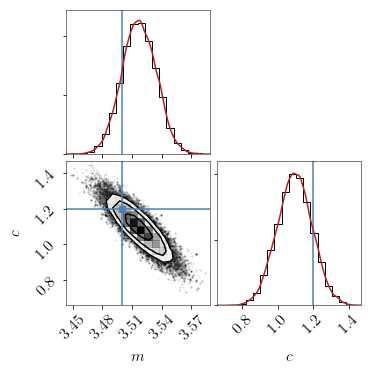

In [10]:
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]
    
    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'normed': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# make plot
plotposts(samples_emcee)

In [11]:
# lets store some results for showing together later
resdict = {}

resdict['memcee_mu'] = np.mean(samples_emcee[:,0])     # mean of m samples
resdict['memcee_sig'] = np.std(samples_emcee[:,0])     # standard deviation of m samples
resdict['cemcee_mu'] = np.mean(samples_emcee[:,1])     # mean of c samples
resdict['cemcee_sig'] = np.std(samples_emcee[:,1])     # standard deviation of c samples
resdict['ccemcee'] = np.corrcoef(samples_emcee.T)[0,1] # correlation coefficient between parameters

Alternatively, we can use some handy utilities in emcee to draw samples from around an initial guess. 

The time to convergence can depend greatly on how the initial points are set up, so if you have a better guess as to the region of the parameter inference posterior, then using those guesses is advised. Beware overtuning, however. If you want to really break things, try cranking `m_std` and `c_std` up and down, as well as moving the center of the ball around (including to the right location but with wide and narrow widths around it. Run for fewer and greater samples to see if the answer changes --- that indicates how fast one converges...

If you knew that your parameter uncertainties were widely different, or possibly varied together, you could use `sample_ellipsoid` to generate a sample cloud which had variances which were different in different dimensions, as well as accounting for possible covariances between the parameters. Note that we generate a sample with the `size` parameter of the number of samples needed to initialize the `EnsembleSampler`. In the example below, we use the `msigma` width from above to define the "radius" of our ball. 

In [12]:
from emcee.utils import sample_ball
m_guess, c_guess = 1., 1.
m_std, c_std = 1., 1.

inisamples = sample_ball((m_guess, c_guess), (m_std, c_std), size=Nens)

In [13]:
# reset so we don't pick up the result from earlier
sampler.reset()

# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 3.94329595566 seconds


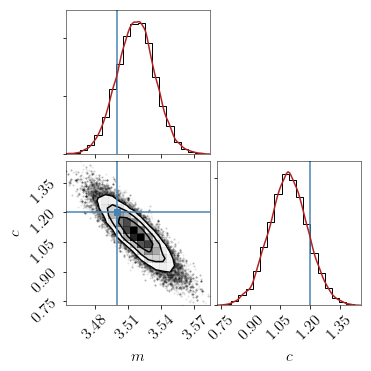

In [14]:
# plot the resulting posteriors
plotposts(samples_emcee)

Once the sampler has settled, the samples that come out of MCMC will be drawn from the posterior. However, even in the best of situations, draws which are adjacent are often correlated with each other. The number of "independent" samples, that is, fully independent draws from the posterior can be much fewer than the samples in hand.

In the example below, the `c` input parameter indicates the number of auto-correlation lengths (ACLs) needed to "reliable" calculate the ACL itself. We set it to 1 here because oftentimes, the sampler has not collected enough samples to satsify the default value of 10.

In [15]:
m_acl, c_acl = sampler.get_autocorr_time(c=1)
print("The autocorrelation length for m is {0} and c is {1}".format(m_acl, c_acl))

The autocorrelation length for m is 17.2663174681 and c is 21.7512320136


However, notice that the answer you get (if you get one at all) changes if you increase the argument of `c` in the function above. This is because the ACL is only relaible when you have several autocorrelation lengths (e.g. more samples) over which to calculate it. This is why the argument `c` is set to be 10. You can, however, use this as a barometer as to whether or not you have converged.

In [16]:
# Chris P
# This is the number of "independent" samples I want from the posterior
n_indp = 100

# reset so we don't pick up the result from earlier
sampler.reset()

# Run the MCMC in a loop until the number of indepdenent samples is reached
n_samp = 0
pos = inisamples
while n_samp <= n_indp:

    # Generate in blocks of 10x the number of independent saples
    # this is an arbitrary number, but the process has no formal
    # end, so this is a reasonable guess
    # We save the final position from each iteration for the next
    # iteration
    pos, _, _ = sampler.run_mcmc(pos, 10 * n_indp);
    
    # Count down the minimum number of ACLs used to relaibly estimate it
    # We don't have to do this, but it's useful to know where one is
    # in convergence
    for i in reversed(range(11)):
        try:
            acls = sampler.get_autocorr_time(c=i)
        except Exception as e:
            continue
        # If we can calculate the ACL, this is the largest value of
        # the c argument we can do it for, so we stop here.
        break

    # Now, we check the ACL for the chain
    # we respect the number of samples required (c * n_samples) to reliably
    # estimate the ACL --- if this condition is not met, we continue to sample
    if i == 10:
        print("ACL estimate has converged, ACL for m is {0:.1f} and for c is {1:.1f}".format(*acls))
    elif i > 0:
        print("ACL esttimate not yet converged, ACL for m is {0} and for c is {1}".format(*acls))
        print("# of ACLs acquired {0:d}".format(i))
        continue
    else:
        # In case we can't generate an ACL estimate at all.
        continue
    
    # We use the parameter with the maximum ACL as the ACL for the
    # entire parameter set
    n_samp = sampler.flatchain.shape[0] / int(acls.max())
    
# extract the samples (removing the burn-in)
samples_emcee = sampler.flatchain[Nburnin::int(acls.max())]

ACL esttimate not yet converged, ACL for m is 22.3577709686 and for c is 54.6356551517
# of ACLs acquired 3
ACL esttimate not yet converged, ACL for m is 22.6958308807 and for c is 53.5747476924
# of ACLs acquired 4
ACL esttimate not yet converged, ACL for m is 22.7529572194 and for c is 49.1126960442
# of ACLs acquired 5
ACL esttimate not yet converged, ACL for m is 22.6816392089 and for c is 45.7290220855
# of ACLs acquired 6
ACL esttimate not yet converged, ACL for m is 22.645511833 and for c is 43.2308121282
# of ACLs acquired 7
ACL esttimate not yet converged, ACL for m is 22.6188492484 and for c is 41.4959305173
# of ACLs acquired 8
ACL esttimate not yet converged, ACL for m is 22.6175454601 and for c is 40.3992275349
# of ACLs acquired 9
ACL estimate has converged, ACL for m is 22.5 and for c is 38.9


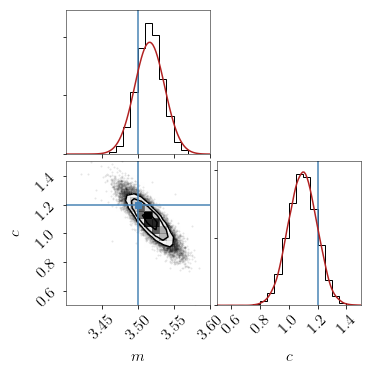

In [17]:
# plot the resulting posteriors
plotposts(samples_emcee, range=((3.4, 3.6), (0.5, 1.5)))

### PyMC3

[PyMC3](http://docs.pymc.io/) ([Salvatier, Wiecki & Fonnesbeck, 2016](https://peerj.com/articles/cs-55/)) is a Python MCMC implementation that can use a variety of modern sampling method, including "No-U-turn sampling" (NUTS) ([Hoffman & Gellman, 2014](http://www.jmlr.org/papers/v15/hoffman14a.html)) and [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) ([Duane _et al_, 1987](http://www.sciencedirect.com/science/article/pii/037026938791197X)), both of which make use of the gradient of the posterior to efficiently sample the space. An example of getting started using PyMC3 can be found [here](http://docs.pymc.io/notebooks/getting_started), and upon which this example is based.

This code can also be [installed](http://docs.pymc.io/#installation) using `pip` with:

```bash
pip install pymc3
```

or with [Conda](https://conda.io/docs/index.html) using:

```bash
conda install -c conda-forge pymc3
```
and the source is available on GitHub [here](https://github.com/pymc-devs/pymc3).

The majority of distributions that can be used for priors and likelihood functions are [predefined](http://docs.pymc.io/api/distributions.html) in PyMC3, so you do not have to worry about writing them yourself (although you can create your [own custom distribution](http://docs.pymc.io/notebooks/getting_started.html#Arbitrary-distributions)).

To set up the model we can't just use the `straight_line()` function defined above, but can do the following:

In [12]:
import pymc3 as pm # import PyMC3

# set the PyMC3 model
linear_model = pm.Model()

with linear_model:
    # set prior parameters
    cmin = -10. # lower range of uniform distribution on c
    cmax = 10.  # upper range of uniform distribution on c
    
    mmu = 0.     # mean of Gaussian distribution on m
    msigma = 10. # standard deviation of Gaussian distribution on m
    
    # set priors for unknown parameters
    cmodel = pm.Uniform('c', lower=cmin, upper=cmax) # uniform prior on y-intercept
    mmodel = pm.Normal('m', mu=mmu, sd=msigma)       # Gaussian prior on gradient
    
    sigmamodel = sigma # set a single standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Gaussian likelihood (sampling distribution) of observations, "data"
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=data)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now we can perform the sampling. By default, for continuous variables like we have, the [sampling step method](http://docs.pymc.io/api/inference.html#step-methods) will use [NUTS](http://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts), but the method can be chosen manually. We'll run with 1000 samples, and tune (like the burn-in discussed [above](#MCMC-set-up)) with 1000 samples (discarding these tuning samples):

In [13]:
%%capture
Nsamples = 1000 # final number of samples
Ntune = 1000    # number of tuning samples

# perform sampling
t0 = time()
with linear_model:
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True); # perform sampling
t1 = time()

timepymc3 = (t1-t0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, c_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [14]:
print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))

Time taken to run 'PyMC3' is 31.738852500915527 seconds


PyMC3 has its own in-built [plotting functions](http://docs.pymc.io/api/plots.html) to, for example, show traces of the MCMC chains.

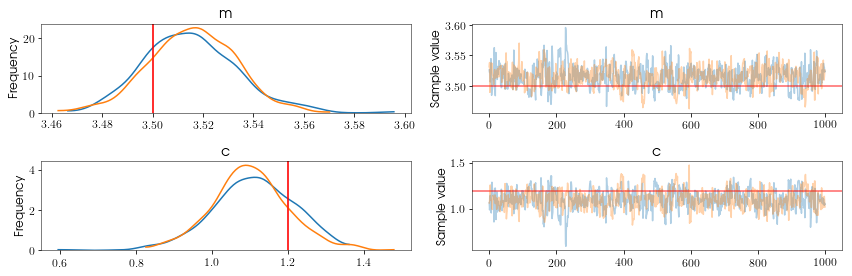

In [15]:
# plot trace output (overplot the true values)
mpl.rcParams.update({'font.size': 12}) # make font-size smaller

_ = pm.traceplot(trace, lines={'m': m, 'c': c})

But, for consistency let's also make a corner plot!

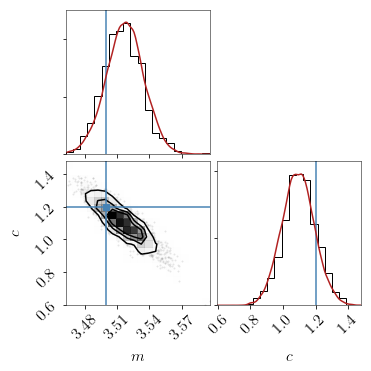

In [16]:
mpl.rcParams.update({'font.size': 16}) # reset the font size

samples_pymc3 = np.vstack((trace['m'], trace['c'])).T

resdict['mpymc3_mu'] = np.mean(samples_pymc3[:,0])      # mean of m samples
resdict['mpymc3_sig'] = np.std(samples_pymc3[:,0])      # standard deviation of m samples
resdict['cpymc3_mu'] = np.mean(samples_pymc3[:,1])      # mean of c samples
resdict['cpymc3_sig'] = np.std(samples_pymc3[:,1])      # standard deviation of c samples
resdict['ccpymc3'] = np.corrcoef(samples_pymc3.T)[0,1]  # correlation coefficient between parameters

plotposts(samples_pymc3)

### MCMC wrapper samplers

There are other MCMC samplers that are not pure Python packages, but have a Python-based wrapper to a different library. With these you can't write pure Python model and probability functions, but instead have a create a code string that is then compiled and run using the underlying library functions. We will look at [PyStan](http://pystan.readthedocs.io) and [PyJAGS](https://pyjags.readthedocs.io).

### PyStan

[PyStan](http://pystan.readthedocs.io) is a Python interface to the popular [Stan](http://mc-stan.org/) library. As with [PyMC3](#PyMC3), it uses the modern NUTS and Hamiltonain MC sampling methods. It can be [installed](http://pystan.readthedocs.io/en/latest/getting_started.html#installation) using `pip` with:

```bash
pip install pystan
```

and the source code is available on GitHub [here](https://github.com/stan-dev/pystan).

To define the model and distributions you need to write a code string like this:

In [17]:
# model and distributions for straight line fitting
line_code = """
data {{
    int<lower=0> N;      // number of data points
    real y[N];           // observed data points
    real x[N];           // abscissa points
    real<lower=0> sigma; // standard deviation
}}
parameters {{
    // parameters for the fit
    real m;
    real c;
}}
transformed parameters {{
    real theta[N];
    for (j in 1:N)
    theta[j] = m * x[j] + c; // straight line model
}}
model {{
    m ~ normal({mmu}, {msigma});     // prior on m (gradient)
    c ~ uniform({clower}, {cupper}); // prior on c (y-intercept)
    y ~ normal(theta, sigma);        // likelihood of the data given the model
}}
"""

You can then define the inputs to the `data` section in a dictionary:

In [18]:
# set the data and the abscissa
linear_data = {'N': M,          # number of data points
               'y': data,       # observed data (converted from numpy array to a list)
               'x': x,          # abscissa points (converted from numpy array to a list)
               'sigma': sigma}  # standard deviation

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [19]:
%%capture
import pystan # import PyStan

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0    # mean of Gaussian prior distribution for m
linedict['msigma'] = 10  # standard deviation of Gaussian prior distribution for m
linedict['clower'] = -10 # lower bound on uniform prior distribution for c
linedict['cupper'] = 10  # upper bound on uniform prior distribution for c

t0 = time()
sm = pystan.StanModel(model_code=line_code.format(**linedict)); # compile model
t1 = time()

timepystancomp = (t1-t0)

t0 = time()
fit = sm.sampling(data=linear_data, iter=Nsamples, chains=chains); # perform sampling
t1 = time()

timepystan = (t1-t0)

In [20]:
print("Time taken to comile 'PyStan' model is {} seconds".format(timepystancomp))
print("Time taken to run 'PyStan' is {} seconds".format(timepystan))

Time taken to comile 'PyStan' model is 44.567866563797 seconds
Time taken to run 'PyStan' is 0.1527576446533203 seconds


PyStan does have a plotting function (you could run `fit.plot()`), but we'll extract the chains and use `corner.py`:

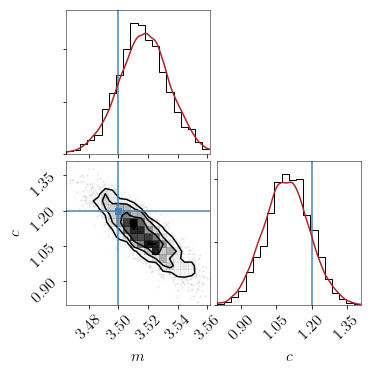

In [21]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

samples_pystan = np.vstack((la['m'], la['c'])).T

resdict['mpystan_mu'] = np.mean(samples_pystan[:,0])      # mean of m samples
resdict['mpystan_sig'] = np.std(samples_pystan[:,0])      # standard deviation of m samples
resdict['cpystan_mu'] = np.mean(samples_pystan[:,1])      # mean of c samples
resdict['cpystan_sig'] = np.std(samples_pystan[:,1])      # standard deviation of c samples
resdict['ccpystan'] = np.corrcoef(samples_pystan.T)[0,1] # correlation coefficient between parameters

# plot using corner.py
plotposts(samples_pystan)

### PyJAGS

[PyJAGS](https://pyjags.readthedocs.io) is another wrapper to a non-Python library, in this case the [JAGS](http://mcmc-jags.sourceforge.net/) ([Plummer, 2003](http://www.ci.tuwien.ac.at/Conferences/DSC-2003/Proceedings/Plummer.pdf)). As with PyStan, you have to write a code string that is then compiled and run. To use PyJAGS you need to install JAGS, e.g. on a Debian-based system this can be done using:

```bash
sudo apt-get install jags
```

and then [install](https://pyjags.readthedocs.io/en/latest/getting_started.html#installation) PyJAGS using `pip` with:

```bash
pip install pyjags
```

The source code for PyJAGS is available on GitHub [here](https://github.com/tmiasko/pyjags).

A linear regression fitting example using PyJAGS is given [here](https://pyjags.readthedocs.io/en/latest/getting_started.html), on which this example is based.

We can define the model string using (note that in this model the Gaussian/Normal distribution takes the inverse variance as the second argument, rather than the standard deviation):

In [22]:
# create the JAGS code for the linear model
line_code_jags = '''
model {{
    for (i in 1:N) {{
        y[i] ~ dnorm(c + m * x[i], {invvar}) # Gaussian likelihood
    }}
    m ~ dnorm({mmu}, {minvvar})     # Gaussian prior on m
    c ~ dunif({clower}, {cupper})   # Uniform prior on c
}}
'''

You can then define the data inputs section in a dictionary:

In [23]:
datadict = {'x': x,    # abscissa points (converted from numpy array to a list)
            'N': M,    # number of data points
            'y': data} # the observed data

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [24]:
%%capture
import pyjags # import PyJAGS

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0           # mean of Gaussian prior distribution for m
linedict['minvvar'] = 1/10**2   # inverse variance of Gaussian prior distribution for m
linedict['clower'] = -10        # lower bound on uniform prior distribution for c
linedict['cupper'] = 10         # upper bound on uniform prior distribution for c
linedict['invvar'] = 1/sigma**2 # inverse variance of the data

# compile model
t0 = time()
model = pyjags.Model(line_code_jags.format(**linedict), data=datadict, chains=chains)
t1 = time()

timepyjagscomp = (t1-t0)

t0 = time()
samples = model.sample(Nsamples, vars=['m', 'c']) # perform sampling
t1 = time()

timepyjags = (t1-t0)

In [25]:
print("Time taken to comile 'PyJAGS' model is {} seconds".format(timepyjagscomp))
print("Time taken to run 'PyJAGS' is {} seconds".format(timepyjags))

Time taken to comile 'PyJAGS' model is 0.24120879173278809 seconds
Time taken to run 'PyJAGS' is 0.16036224365234375 seconds


Now we can plot the samples using `corner.py`:

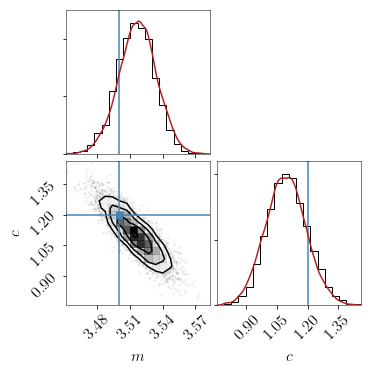

In [26]:
mchainjags = samples['m'].flatten()
cchainjags = samples['c'].flatten()

samples_pyjags = np.vstack((mchainjags, cchainjags)).T

resdict['mpyjags_mu'] = np.mean(samples_pyjags[:,0])      # mean of m samples
resdict['mpyjags_sig'] = np.std(samples_pyjags[:,0])      # standard deviation of m samples
resdict['cpyjags_mu'] = np.mean(samples_pyjags[:,1])      # mean of c samples
resdict['cpyjags_sig'] = np.std(samples_pyjags[:,1])      # standard deviation of c samples
resdict['ccpyjags'] = np.corrcoef(samples_pyjags.T)[0,1] # correlation coefficient between parameters

# plot using corner.py
plotposts(samples_pyjags)

That ends our exploration of MCMC codes. We now move on to Nested Sampling!

## Nested Sampling

[Nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) ([Skilling, 2006](https://projecteuclid.org/euclid.ba/1340370944)) is a method to numerically perform the integral required to evaluate the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data given a particular model. This is not a value that is produced by most standard MCMC methods, but is a value that is very useful if wanting to do [Bayesian model comparison](https://en.wikipedia.org/wiki/Bayes_factor). Above, we defined the marginal likelihood, or _evidence_, as

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

but, we can make this more explicit for a given hypothesis, or model, $H_j$, by stating:

$$
p(\mathbf{d}|H_j, I) \equiv Z = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta}, H_j, I) p(\vec{\theta}|H_j,I) {\rm d}{\theta_i},
$$

where previously the $H_j$ had been subsumed inside our implicit assumptions, $I$.

Nested sampling algorithms generally start by drawing a set of points (sometimes called _"live points"_, or _"active points"_) from the prior distribution. It relies on these points truely being independent draws from the prior, otherwise the resulting marginal likelihood value can be biased. The likelihood is evaluated at each point, and the smallest likelihood point is found. This points is then removed from the set of live points (and goes into the sum calculating the marginal likelihood integral) and a new point is drawn from the prior with the constraint that it has a likelihood larger than the just removed point. Drawing truely independent points from this constrained prior is the main tricky part of nested sampling (particularly when the number of parameters is not small), and a variety of methods (including MCMC methods) can be used.

The uncertainty on the estimate of the natural logarithm marginal likelihood, $\ln{Z}$, can be found if the information gain (or [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)), $h$, in going from the prior to the posterior is calculated. If $h$ (in [nats](https://en.wikipedia.org/wiki/Nat_%28unit%29)) is available then the uncertainty is ([Skilling, 2006](https://projecteuclid.org/euclid.ba/1340370944)):

$$
\sqrt{\frac{h}{N_{\rm live}}},
$$

where $N_{\rm live}$ is the number of live points used.

> _Note_: _This is the statistical uncertainty on the value, but if there are any biases due to the sampling not being independent draws from the prior then there can be systematic uncertainties too._

As well as producing a value for the marginal likelihood, a by-product of the nested sampling algorithm to to produce a set of samples that can be re-sampled from to produce samples drawn from the posterior distribution.

> _Note_: _MCMC methods can be used to estimate the marginal likelihood, e.g. `emcee` can be run with a [parallel tempering sampling method](http://dfm.io/emcee/current/user/pt/) and used to compute the evidence using thermodynamic integration (e.g., [Goggans & Chi, 2004](http://aip.scitation.org/doi/abs/10.1063/1.1751356)), or potentially using Slice sampling with PyMC3._

As with MCMC, there are various codes available to perform the nested sampling algorithm. We will again look at pure Python implementations and some that are wrappers to other libraries.

### Nestle

[Nestle](http://kylebarbary.com/nestle/) is a pure Python nested sampling algorithm. It has three options for the method with which it draws new samples: ["classic"](http://kylebarbary.com/nestle/#mcmc-exploration-method-classic), ["single ellipsoid"](http://kylebarbary.com/nestle/#single-ellipsoid-method-single), and ["multiple ellipsoids](http://kylebarbary.com/nestle/#multiple-ellipsoids-method-multi). In this example we'll make use of the last of these. This uses the MultiNest method (also see [PyMultiNest below](#PyMultiNest)) ([Feroz _et al_, 2009](https://arxiv.org/abs/0809.3437)) in which the current live points are clustered (however, clustering is not re-done at every iteration of the algorithm), ellipsoids completely bounding each cluster are found, an ellipsoid is randomly chosen with a probability proportional to its volume, and a new sample is drawn uniformly from it.

Nestle is available on PyPI and installable using `pip` with:

```bash
pip install nestle
```

The source code is available on GitHub [here](https://github.com/kbarbary/nestle).

The set up of likelihood functions is quite similar to that for [emcee](#emcee), but the prior that is used is a unit hypercube (an $n$-dimensional cube with all sides equal to one), so parameters must be mapped into this space. This is simple for uniform priors, but requires a [re-parameterisation](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables) using a [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) for more complex priors (if possible).

For our Gaussian prior on $m$ we can't analytically re-parameterise it for a unit hypercube, however we can use [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to take samples from a uniform range between 0 and 1, and convert them back to a Gaussian, e.g.

$$
m = \mu_m + \sqrt{2}\sigma_m {\rm erf}^{-1}\left(2c - 1\right),
$$

where $c \sim {\rm Uniform}(0,1)$ and ${\rm erf}^{-1}$ is the [inverse error function](https://en.wikipedia.org/wiki/Error_function#Inverse_functions). As [shown in the Nestle documentation](http://kylebarbary.com/nestle/prior.html#non-uniform-priors) we can use the [`scipy.special.ndtri`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ndtri.html#scipy.special.ndtri) function for this.

An example of using Nestle for the linear regression problem, but with uniform priors on both parameters, is given [here](http://kylebarbary.com/nestle/examples/plot_line.html#sphx-glr-examples-plot-line-py).

#### Setting the prior transform

Given the above description, rather than setting a prior function, we set a [prior transformation function](http://kylebarbary.com/nestle/prior.html) that maps from parameters drawn from the unit hypercube into the true parameters.

In [27]:
# import the inverse error function from scipy
from scipy.special import ndtri

def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)

#### Setting the likelihood function

This is similar to setting the likelihood function for [emcee](#Likelihood) except, as we're calculating the marginal likelihood, we will keep the normalisation constants. As before, we work with the natural logarithm of the likelihood function. The function can only take in a tuple variable containing the parameter values, so any additional required values must be hard coded, or set as global variables.

In [28]:
# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma) # natural log of the data noise standard deviation

def loglikelihood_nestle(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

Now you can run the sampler. We'll use 1024 live/active points (there's nothing special about this number, and powers of two are not required). The more live points you use the longer the code will take to run, but the uncertainty on the final marginal likelihood value will decrease with greater numbers of live points. 

Unlike with MCMCs, where you give it a number of iterations to run and after that point it stops, nested sampling needs to be supplied with a [stopping criterion](http://kylebarbary.com/nestle/stopping.html) at which point it will terminate. One common [criterion](http://kylebarbary.com/nestle/stopping.html#estimated-remaining-evidence) is based on the ratio between an estimate of the total evidence and the current calculated evidence value. Once this value gets below some set value the algorithm will terminate.

In [29]:
# import nestle
import nestle

nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol= 0.5         # the stopping criterion (this is the nestle default, so doesn't need to be set)

t0 = time()
res = nestle.sample(loglikelihood_nestle, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol)
t1 = time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

Time taken to run 'Nestle' is 1.3580248355865479 seconds


We can extract the value of the marginal likelihood, $\ln{Z}$, and its uncertainties with the following:

In [30]:
logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print(six.u('log(Z) = {} \u00B1 {}'.format(logZnestle, logZerrnestle)))

log(Z) = -87.8954347746784 ± 0.10161343969087715


A summary of the above values can also be output using:

In [31]:
print(res.summary())

niter: 12737
ncall: 20908
nsamples: 13761
logz: -87.895 +/-  0.102
h: 10.573


As mentioned above, the samples output by nested sampling are not drawn from the posterior, and as such need to be resampled from using certain weights. These weights are output by Nestle in the results. We can get posterior samples with the following:

In [32]:
# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]

resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

Number of posterior samples is 2444


Now we can plot the posteriors:

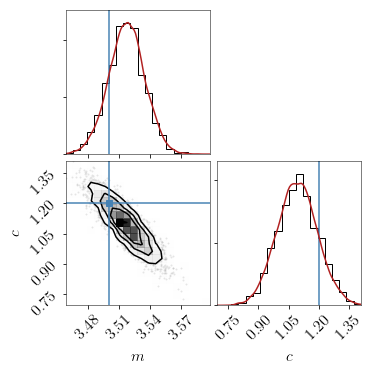

In [33]:
plotposts(samples_nestle)

### CPNest

[CPNest](https://johnveitch.github.io/cpnest/) ([Veitch & del Pozzo, 2017](http://doi.org/10.5281/zenodo.835874)) is another pure Python nested sampling algorithm. To perform the sampling from the restricted prior it uses a [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) based MCMC, with sample proposal distributions that use a combination of the affine invarient ensemble methods described for [emcee](#emcee) ([Goodman & Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml)), [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution), or jumps based on the eigenvectors of the covariance matrix of live points.

CPNest is available on PyPI and can be installed using `pip` with: 

```bash
pip install cpnest
```

The source code is available on GitHub [here](https://github.com/johnveitch/cpnest/).

To run CPNest we have to define a [class](https://docs.python.org/3/tutorial/classes.html) containing the likelihood and prior functions. CPNest also requires explicit bounds on all parameters from which it will uniformly draw an initial set of live points. Prior to running the nested sampling algorithm, it will run an MCMC using the prior as the target distribution to make sure the samples are drawn from the required prior.

In [34]:
# import the Model class from CPNest
from cpnest.model import Model

LN2PI = np.log(2.*np.pi)

# set the model, likelihood and prior
class StraightLineModel(Model):
    """
    A simple straight line model, with a Gaussian likelihood.
    
    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        
    """
    names = ['m','c'] # parameter names (this is a required variables for the class)

    # define the boundaries using for initial sampling of the live points
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    cbounds = [cmin, cmax]
    # set the m bounds to be +/- 10sigma about the mean
    mbounds = [mmu-10.*msigma, mmu+10.*msigma]

    # NOTE: the bounds could instead be set through arguments passed to the __init__
    # function for the class if wanted
    bounds=[mbounds, cbounds] # upper and lower bounds on each parameter (required for the class)

    def __init__(self, data, abscissa, modelfunc, sigma):
        # set the data
        self._data = data         # oberserved data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

    def log_likelihood(self, params):
        """
        The natural logarithm of the likelihood function.

        Args:
            params (dict): a dictionary keyed to the parameter names.

        Returns:
            float: the log likelihood value.
        """
        # extract the parameters
        m = params['m']
        c = params['c']

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

    def log_prior(self,p):
        """
        The natural logarithm of the prior function.

        Args:
            p (dict): a dictionary keyed to parameter names.

        Returns:
            float: The log prior value.
        """
        # the uniform priors are dealt with by just checking that we're within the bounds
        if not self.in_bounds(p): return -np.inf # check parameters are all in bounds

        # Gaussian prior on m
        lp = 0.
        m = p['m']
        lp -= 0.5*((m-self.mmu)/self.msigma)**2 # no need for normalisation constant on the prior

        return lp

We can now run CPNest. As with Nestle we will use 1024 live points. CPNest can use mutltiple CPU cores, but we'll set it to use one to be comparable to the other tests. The number of iterations used for the MCMC sampling is automatically worked out within the code by calculating autocorrelation lengths to see how many iterations are needed to produce independent samples, but a maximum chain length can also be set. We'll set this to 1024. As with Nestle a stopping criterion is required, which for CPNest is defined in the same way as Nestle. However, the current CPNest default is 0.1 and this cannot be altered by the user.

In [35]:
%%capture
# import cpnest
import cpnest

nlive = 1024      # number of live point
maxmcmc = 1024    # maximum MCMC chain length
nthreads = 1      # use one CPU core

# set up the algorithm
work = cpnest.CPNest(StraightLineModel(data, x, straight_line, sigma), verbose=0,
                     Nthreads=nthreads, Nlive=nlive, maxmcmc=maxmcmc);
# run the algorithm
t0 = time()
work.run();
t1 = time()

timecpnest = (t1-t0)

In [36]:
print("Time taken to run 'CPNest' is {} seconds".format(timecpnest))

Time taken to run 'CPNest' is 17.54936695098877 seconds


We can again extract the value of $\ln{Z}$ and its uncertainty. One simple bit of model comparison that we may want to do is compare the evidence for the model of the data containg a straight line (with the given priors on the parameter), with the evidence for a model that the data just contains independent Gaussian noise with the given standard deviation. We can calculate the latter evidence easily by just setting the model to zero in the log-likelihood function, e.g.:

$$
\ln{Z}_{\rm noise} = -\frac{M}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^M \sigma_i\right) - \sum_{i=1}^M\frac{d_i^2}{2\sigma_i^2}.
$$

The natural logarithm of the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) comparing the two models is then:

$$
\ln{\mathcal{B}} = \ln{Z} - \ln{Z}_{\rm noise}.
$$

We will also extract this value.

In [37]:
logZcpnest = work.NS.logZ                     # value of log Z
infogaincpnest = work.NS.state.info           # value of the information gain
logZerrcpnest = np.sqrt(infogaincpnest/nlive) # estimate of the statistcal uncertainty on logZ

# get the null log likelihood (evidence that the data is Gaussian noise with zero mean, and given standard devaition)
logZnull = work.user.log_likelihood({'m': 0., 'c': 0.})

print(six.u('log(Z) = {} \u00B1 {}'.format(logZcpnest, logZerrcpnest)))

# output the log Bayes factor
print('log Bayes factor is {}'.format(logZcpnest - logZnull))

log(Z) = -87.63772889049628 ± 0.10058727951905937
log Bayes factor is 89069.82342915935


CPNest will itself resample from the nested samples to give posterior samples held in a dictionary, which we can plot.

Number of posterior samples is 2733


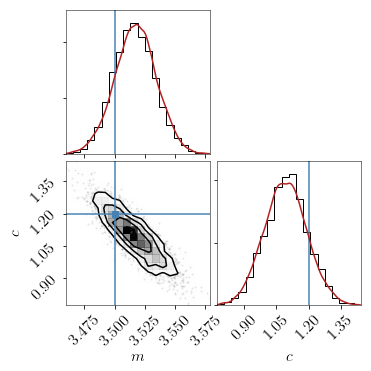

In [38]:
mchain_cpnest = work.posterior_samples['m'] # extract chain of m values
cchain_cpnest = work.posterior_samples['c'] # extract chain if c values
samples_cpnest = np.vstack((mchain_cpnest, cchain_cpnest)).T

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_cpnest.shape[0]))

resdict['mcpnest_mu'] = np.mean(samples_cpnest[:,0])      # mean of m samples
resdict['mcpnest_sig'] = np.std(samples_cpnest[:,0])      # standard deviation of m samples
resdict['ccpnest_mu'] = np.mean(samples_cpnest[:,1])      # mean of c samples
resdict['ccpnest_sig'] = np.std(samples_cpnest[:,1])      # standard deviation of c samples
resdict['cccpnest'] = np.corrcoef(samples_cpnest.T)[0,1]  # correlation coefficient between parameters
resdict['cpnest_npos'] = len(samples_cpnest)              # number of posterior samples
resdict['cpnest_time'] = timecpnest                       # run time
resdict['cpnest_logZ'] = logZcpnest                       # log marginalised likelihood
resdict['cpnest_logZerr'] = logZerrcpnest                 # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_cpnest)

We will now look at some nested sampling algorithms that are not pure Python, but do have Python wrappers.

### PyMultiNest

[PyMultiNest](http://johannesbuchner.github.io/PyMultiNest/) ([Buchner _et al_, 2014](https://www.aanda.org/articles/aa/abs/2014/04/aa22971-13/aa22971-13.html)) is a wrapper to the popular [MultiNest](https://ccpforge.cse.rl.ac.uk/gf/project/multinest/) code ([Feroz & Hobson, 2008](http://xxx.lanl.gov/abs/0704.3704) & [Feroz _et al_, 2009](http://xxx.lanl.gov/abs/0704.3704)), which has been particularly taken up by the astrophysics and cosmology community. The basics underlying MultiNest were described in relation to [Nestle](#Nestle), although MultiNest can use more sophisticated sampling methods, such as importance sampling ([Feroz _et al_, 2014](http://xxx.lanl.gov/abs/1306.2144v2)).

To use PyMultiNest, the MultiNest library itself must be installed. MultiNest can be downloaded from [here](https://ccpforge.cse.rl.ac.uk/gf/project/multinest/), although you must have registered an account with [CCPForge](https://ccpforge.cse.rl.ac.uk/gf/) to download the file. If you have the file, e.g., `MultiNest_v3.10_CMake.tar.gz`, then you can unzip the tarball with:

```bash
tar -xvzf MultiNest_v3.10_CMake.tar.gz
```

You can then compile it using [CMake](https://cmake.org/), with the following:

```bash
cd MultiNest_v3.9_CMake/multinest/build
cmake ..
make
```

and install it (to `/usr/local/` by default) with

```bash
sudo make install
```

You can then install PyMultiNest using `pip` with:

```bash
pip install pymultinest
```

> **Note**: this example works with MultiNest version **3.10** and PyMultiNest [version **2.6**](https://pypi.python.org/pypi/pymultinest/2.6), but has not been tested for any other versions. If using MultiNest, and software wrapping it, for your work please note the software license restrictions [here](http://www.mrao.cam.ac.uk/~ff235/MultiNest_License.pdf). 

Some examples of running PyMultiNest can be found [here](http://johannesbuchner.github.io/pymultinest-tutorial/), although an interface through a [`solver` function](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_demo.py) and [`Solver` class](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_solver_demo.py) are also available. We'll use the `Solver` class method, which can take in the same initialisation keyword arguments as the [`run()` method](http://johannesbuchner.github.io/PyMultiNest/pymultinest_run.html).

We use the `Solver` class to create a new class for our specific example. As with [CPNest](#CPNest) we use this class to define our log likeihood function, and like [Nestle](#Nestle) we define a prior transform to go from a unit hypercube to the true parameterisation. These functions can only take in arrays of the parameter values that we are exploring and cannot take in additional arguments. Therefore any additional values required must either be global variables, or a new `__init__` method for the class must be defined. We'll show the latter of these.

> _Note_: _PyMultiNest is also available in Python through the_ [Monte Python](http://monte-python.readthedocs.io/en/latest/nested.html) _package._

In [39]:
# import the Solver class
from pymultinest.solve import Solver
from scipy.special import ndtri

LN2PI = np.log(2.*np.pi)

class StraightLineModelPyMultiNest(Solver):
    """
    A simple straight line model, with a Gaussian likelihood.

    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        **kwargs: keyword arguments for the run method
    """

    # define the prior parameters
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        # set the data
        self._data = data         # oberserved data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)

    def Prior(self, cube):
        """
        The prior transform going from the unit hypercube to the true parameters. This function
        has to be called "Prior".

        Args:
            cube (:class:`numpy.ndarray`): an array of values drawn from the unit hypercube

        Returns:
            :class:`numpy.ndarray`: an array of the transformed parameters
        """

        # extract values
        mprime = cube[0]
        cprime = cube[1]

        m = self.mmu + self.msigma*ndtri(mprime)      # convert back to m
        c = cprime*(self.cmax-self.cmin) + self.cmin  # convert back to c

        return np.array([m, c])

    def LogLikelihood(self, cube):
        """
        The log likelihood function. This function has to be called "LogLikelihood".

        Args:
            cube (:class:`numpy.ndarray`): an array of parameter values.

        Returns:
            float: the log likelihood value.
        """

        # extract parameters
        m = cube[0]
        c = cube[1]

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

Now we can run the sampler. As before we'll use 1024 live points, and like with [Nestle](#Nestle) we'll use a stopping criterion of 0.5. By default the sampler will use importance sampling.

In [40]:
%%capture
nlive = 1024 # number of live points
ndim = 2     # number of parameters
tol = 0.5    # stopping criterion

# run the algorithm
t0 = time()
solution = StraightLineModelPyMultiNest(data, x, straight_line, sigma, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)

In [41]:
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

Time taken to run 'PyMultiNest' is 4.927276849746704 seconds


Now we can extract the value of $\ln{Z}$ and its uncertainty.

In [42]:
logZpymnest = solution.logZ        # value of log Z
logZerrpymnest = solution.logZerr  # estimate of the statistcal uncertainty on logZ

print(six.u('log(Z) = {} \u00B1 {}'.format(logZpymnest, logZerrpymnest)))

log(Z) = -87.76988393079637 ± 0.10092196459927992


These solutions, and the mean and standard deviation of the $m$ and $c$ parameters, can also be shown by using:

In [43]:
print(solution)

Model in "(temporary directory)" (2 dimensions)
Evidence ln Z = -87.8 +- 0.1
Parameter values:
   Parameter  1 : 3.517 +- 0.018
   Parameter  2 : 1.093 +- 0.100


We can extract and plot the posteriors. The `solution.samples` value contains an array of the posterior samples rather than the nested samples, so no resamping is required.

Number of posterior samples is 3588


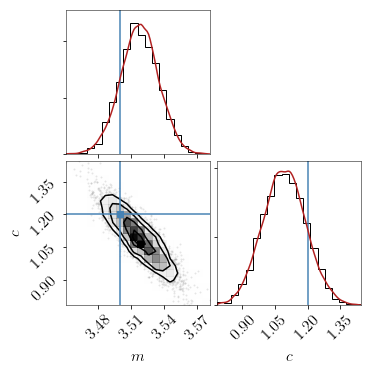

In [44]:
mchain_pymnest = solution.samples[:,0] # extract chain of m values
cchain_pymnest = solution.samples[:,1] # extract chain if c values

samples_pymnest = np.vstack((mchain_pymnest, cchain_pymnest)).T

resdict['mpymnest_mu'] = np.mean(samples_pymnest[:,0])      # mean of m samples
resdict['mpymnest_sig'] = np.std(samples_pymnest[:,0])      # standard deviation of m samples
resdict['cpymnest_mu'] = np.mean(samples_pymnest[:,1])      # mean of c samples
resdict['cpymnest_sig'] = np.std(samples_pymnest[:,1])      # standard deviation of c samples
resdict['ccpymnest'] = np.corrcoef(samples_pymnest.T)[0,1]  # correlation coefficient between parameters
resdict['pymnest_npos'] = len(samples_pymnest)              # number of posterior samples
resdict['pymnest_time'] = timepymultinest                   # run time
resdict['pymnest_logZ'] = logZpymnest                       # log marginalised likelihood
resdict['pymnest_logZerr'] = logZerrpymnest                 # uncertainty on log(Z)

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_pymnest.shape[0]))

# plot using corner.py
plotposts(samples_pymnest)

### DNest4

[DNest4](https://github.com/eggplantbren/DNest4) ([Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757)) uses a nested sampling algorithm called _Diffusive Nested Sampling_ ([Brewer _et al_, 2011](https://arxiv.org/abs/0912.2380)). The main difference between this method and others is that it can at any point still propose samples throughout the whole prior, rather than being contrained to draw points within a range based on the current set of live points. This allows it to find volumes of high likelihood that might be missed by other methods because they lie in an area where no live points remain, i.e. it is good for sampling multi-model posteriors. It can also be used in cases where the number of parameters in the model that is being fit is itself a variable, e.g., if the line model could either be a straight line, or a quadratic, or a cubic. The method used is called a Reversible Jump MCMC ([Green, 1995](https://academic.oup.com/biomet/article/82/4/711/252058)), although this is not currently available in the Python interface for DNest4.

An example of using the Python wrapper for DNest4 for a straight line mode is given [here](https://github.com/eggplantbren/DNest4/blob/master/python/examples/straightline/straightline.py), but we will reproduce it with minor modifications (in that example $\sigma$ is also included in the fitting).

To install DNest4 you first need to clone it from its [GitHub repository](https://github.com/eggplantbren/DNest4):

```bash
git clone https://github.com/eggplantbren/DNest4.git
```

You can then just install the Python module using:

```bash
cd DNest4/python
python setup.py install
```

By default this will install in the `/usr/local` base path, in the `lib/pythonX.X/dist-packages` directory (and as such you need to be a root user or install it with `sudo`), but you can specify the install base path using the `--prefix base_path` argument.

For DNest4 we need to create a `Model` class that contains the following methods:
 * `from_prior()`: a function that draws a sample from the prior distributions of the parameters
 * `perturb()`: a function that proposes new sample values
 * `log_likelihood()`: the natural logarithm of the likelihood function

The `perturb()` method also needs to calculate the natural logarithm of the [Metropolis-Hastings ratio](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) required to give the acceptance probability:

$$
H = \frac{p(\theta'|I)}{p(\theta|I)} \frac{g(\theta|\theta')}{g(\theta'|\theta)},
$$

where the first ratio on the right-hand-side is the ratio of priors at the proposed point $\theta'$ and current point $\theta$, and the second ratio of the ratio of the proposal distributions. In our case the proposal distribution is symmetric, so its ratio is unity, and the ratio of the prior depends on the Gaussian prior on $m$, but not on the uniform prior for $c$.

Parameters cannot be passed to the class on initialisation, so things such as the data must be global variables.

In [45]:
# import randh function that draws points from a heavy-tailed distribution
from dnest4 import randh

LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

class DNest4Model(object):
    """
    Specify the model in Python.
    """
    def __init__(self):
        """
        Parameter values *are not* stored inside the class
        """
        pass

    def from_prior(self):
        """
        Draw points from the prior distribution.

        Returns:
            :class:`np.ndarray`: a numpy array containing the parameter values.
        
        """

        cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
        cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

        mmu = 0.     # mean of the Gaussian prior on m
        msigma = 10. # standard deviation of the Gaussian prior on m

        m = np.random.normal(mmu, msigma)
        c = np.random.uniform(cmin,  cmax)

        return np.array([m, c])

    def perturb(self, params):
        """
        Perturb the current parameters by proposing a new position. This takes a numpy array of
        parameters as input, and modifies it in-place. In just perturbs one parameter at a time.

        Args:
            params (:class:`np.ndarray`): the current parameters (this is modified by the function)

        Returns:
            float: the natural logarithm of the Metropolis-Hastings proposal ratio.
        """
        logH = 0.0 # log of the Metropolis-Hastings prior x proposal ratio
        
        # randomly choose which parameter to perturb 
        which = np.random.randint(len(params))
        mmu = 0.
        msigma = 10.
        if which == 0:
            # update H for Gaussian prior
            logH -= -0.5*((params[which]-mmu)/msigma)**2
        params[which] += 10.*randh() # scale factor of 10, which is ~the prior width
        if which == 0:
            # update H for Gaussian prior
            logH += -0.5*((params[which]-mmu)/msigma)**2

        return logH

    def log_likelihood(self, params):
        """
        Gaussian sampling distribution.
        """
        m, c = params # unpack parameters
        
        norm = -0.5*M*LN2PI - M*LNSIGMA
        chisq = np.sum(((data - straight_line(x, m, c))/sigma)**2)
        return norm - 0.5*chisq

We can now run the sampler. The values that are passed to the sampler are described in Section 7 of [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757), but we'll stick with the defaults used in the [example code](https://github.com/eggplantbren/DNest4/blob/master/python/examples/straightline/straightline.py). Unlike with the other nested sampling algorithms we do not pass a tolerance for the stopping criterion, but just specify the number of levels and steps to perform. The `num_steps` gives to total number of MCMC iterations, but if not set the code will run forever by default, until the process is killed by the user.

In [46]:
# import dnest4
import dnest4

# Create a model object and a sampler
model = DNest4Model()
sampler = dnest4.DNest4Sampler(model, backend=dnest4.backends.CSVBackend(".", sep=" "))

# Set up the sampler. The first argument is max_num_levels
gen = sampler.sample(max_num_levels=30, num_steps=1000, new_level_interval=10000,
                     num_per_step=10000, thread_steps=100, num_particles=5, lam=10, beta=100)

# Do the sampling (one iteration here = one particle save)
t0 = time()
for sample in enumerate(gen):
    pass
t1 = time()

timednest4 = (t1-t0)

print("Time taken to run 'DNest4' is {} seconds".format(timednest4))

Time taken to run 'DNest4' is 296.0087411403656 seconds


To create the posterior samples the output of DNest4 has to be processed, which can be performed using the `postprocess()` function. Once this is done the posterior samples will be held in a `posterior_sample.txt` file containing a column for each parameter. As stated in [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757):

> _"it is harder to compute justified error bars on $\ln{(Z)}$ in DNS than it is in standard NS."_

so we will not quote a value here.

In [47]:
# Run the postprocessing to get marginal likelihood and generate posterior samples
logZdnest4, infogaindnest4, _ = dnest4.postprocess(plot=False);

samples_dnest4 = np.loadtxt('posterior_sample.txt')

log(Z) = -95.9830218049465
Information = 18.62645248138253 nats.
Effective sample size = 157.22971793249965


Now let's plot the posteriors (noting that the effective number of posterior samples is quite a bit smaller than for the other samplers).

Number of posterior samples is 157


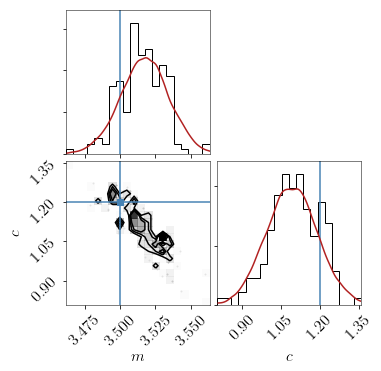

In [48]:
# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_dnest4.shape[0]))

resdict['mdnest4_mu'] = np.mean(samples_dnest4[:,0])      # mean of m samples
resdict['mdnest4_sig'] = np.std(samples_dnest4[:,0])      # standard deviation of m samples
resdict['cdnest4_mu'] = np.mean(samples_dnest4[:,1])      # mean of c samples
resdict['cdnest4_sig'] = np.std(samples_dnest4[:,1])      # standard deviation of c samples
resdict['ccdnest4'] = np.corrcoef(samples_dnest4.T)[0,1]  # correlation coefficient between parameters
resdict['dnest4_npos'] = len(samples_dnest4)              # number of posterior samples
resdict['dnest4_time'] = timednest4                       # run time
resdict['dnest4_logZ'] = logZdnest4                       # log marginalised likelihood

# plot using corner.py
plotposts(samples_dnest4)

### PyPolyChord

[PolyChord](https://ccpforge.cse.rl.ac.uk/gf/project/polychord/) ([Handley _et al_, 2015a](https://arxiv.org/abs/1502.01856), [Handley _et al_, 2015b](https://arxiv.org/abs/1506.00171)) is a nested sampling implementation that uses [slice sampling](https://en.wikipedia.org/wiki/Slice_sampling) when drawing new points from the constrained prior.

The PolyChord package itself provides a Python interface called PyPolyChord for using the algorithm. PolyChord can be downloaded from [here](https://ccpforge.cse.rl.ac.uk/gf/download/frsrelease/595/8827/PolyChord_v1.12.tar.gz), and as with MultiNest it requires a [CCPForge](https://ccpforge.cse.rl.ac.uk/gf/) login. If you have the source tarball `PolyChord_v1.12.tar.gz`, then you can unzip it with

```bash
tar -xvzf PolyChord_v1.12.tar.gz
cd PolyChord
```

which extracts it into a `PolyChord` directory. To install PyPolyChord you can edit the `Makefile`, so that in the `PyPolyChord` section (line 83) you remove/comment out either the `python3` or `python2` command depending on which Python version you are using, then you can run

```bash
make PyPolyChord
```

This will automatically attempt to set a `LD_LIBRARY_PATH` enviroment variable to point to the `libchord.so` library that gets created. It will also attempt to find a copy of the `libmpi.so` library and add a `LD_PRELOAD` enviroment variable pointing to it. If you have not got MPI (or are having further problems with MPI) you can disable it by instead compiling with:

```bash
make MPI= PyPolyChord
```

Using the `Makefile` the Python package will be installed as `--user`, so will be located in `${HOME}/.local/lib/pythonX.X/site-packages`.


As with [Nestle](#Nestle) and [PyMultiNest](#PyMultiNest) PolyChord samples from a unit hypercube, so you need to define a prior transform function. We also need a log likelihood function. These can be very similar to those used for [Nestle](#Nestle), but the functions must take in and output list rather than lists or tuples. Values such as the data array cannot be passed to the functions explicitly, so must be set as global variables.

> **Note**: this example works with PolyChord version **1.12**, but has not been tested for any other versions. If using PolyChord for your work, please note the license restrictions described [here](http://www.mrao.cam.ac.uk/~wh260/PolyChord_Licence.pdf).

In [49]:
from scipy.special import ndtri

LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

def prior_transform_polychord(cube):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        cube (array, list): a list containing the parameters as drawn from a unit hypercube.

    Returns:
        list: the transformed parameters.
    """

    # unpack the parameters (in their unit hypercube form)
    mprime = cube[0]
    cprime = cube[1]
    
    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    theta = [m, c]

    return theta


def loglikelihood_polychord(theta):
    """
    The log-likelihood function.

    Args:
        theta (array, list): the set of parameter values.

    Returns:
        float: the log-likelihood value.
        list: A list of any derived parameters (an empty list if there are none).
    """

    # unpack the parameters
    m = theta[0]
    c = theta[1]

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq, []

As before we'll use 1024 live points (the default is to use 25 times the dimensionality of the problem) and a stopping criterion of 0.5 (the default value is 0.001). The current version of PyPolyChord will return values of the marginal likelihood and its uncertainty from the `PyPolyChord` object that runs the algorithm, but the class does not currently contain the posterior samples. It instead outputs these to files. The location of these files is set by setting the keyword arguments `base_dir` (defaults to "`chains`") and `file_root` (defaults to "`test`") in a `PolyChordSettings` object. This sets `{root} = {base_dir}/{file_root}`, and with this the posterior samples can be found in `{root}.txt` and the other statistics found in `{root}.stats`.

You may find that codes produce a "Segmentation Fault" soon after they start running. The PolyChord documentation says:

> "_The slice sampling & clustering steps use a recursive procedure. The default memory allocated to recursive 
> procedures is embarassingly small (to guard against memory leaks)._"

and the solution is to:

> Try increasing the stack size:  
> Linux:    `ulimit -s unlimited`  
> OSX:      `ulimit -s hard`

Alternatively, within a Python script you can achieve this using the [`resource`](https://docs.python.org/2/library/resource.html) module, as shown below.

In [50]:
import resource
curlimit = resource.getrlimit(resource.RLIMIT_STACK)
resource.setrlimit(resource.RLIMIT_STACK, (resource.RLIM_INFINITY,resource.RLIM_INFINITY))

In [51]:
nlive = 1024   # number of live points
ndims = 2      # number of parameters
nderived = 0   # number of derived parameters (this is zero)
tol = 0.5      # stopping criterion
basedir = os.path.join(os.getcwd(), 'polychord')  # output base directory
if not os.path.isdir(basedir):
    os.makedirs(basedir)                          # create base directory
    os.makedirs(os.path.join(basedir, 'clusters'))
fileroot = 'straightline'                         # output file name
broot = os.path.join(basedir, fileroot)

# import PolyChord
import PyPolyChord
from PyPolyChord.settings import PolyChordSettings  # class for passing setup information
from PyPolyChord.priors import UniformPrior         # pre-defined class for a uniform prior

# setup run settings using the PolyChordSetting class
pargs = {'nlive': nlive,
         'precision_criterion': tol,
         'base_dir': basedir,
         'file_root': fileroot,
         'write_resume': False, # don't output a resume file
         'read_resume': False}  # don't read a resume file
settings = PolyChordSettings(ndims, nderived, **pargs)

t0 = time()
output = PyPolyChord.run_polychord(loglikelihood_polychord, ndims, nderived, settings, prior_transform_polychord)
t1 = time()

timepolychord = (t1-t0)

print("Time taken to run 'PyPolyChord' is {} seconds".format(timepolychord))

# reset stack resource limit
resource.setrlimit(resource.RLIMIT_STACK, curlimit)

Time taken to run 'PyPolyChord' is 8.609043836593628 seconds


We can extract the marginal likelihood and the uncertainty from the `output` variable. 

In [52]:
print(six.u('log(Z) = {} \u00B1 {}'.format(output.logZ, output.logZerr)))

log(Z) = -87.919303 ± 0.10238051


We can also extract the posterior samples from the file with the `_equal_weights.txt` suffix. Given we have two parameters, the chains for these will be the final two columns within the samples file.

Number of posterior samples is 2605


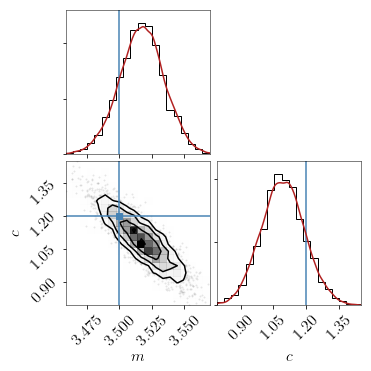

In [53]:
samplefile = broot+'_equal_weights.txt'
samples_polychord = np.loadtxt(samplefile)
samples_polychord = samples_polychord[:,-ndims:] # extract the last 'ndims' columns

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_polychord.shape[0]))

resdict['mpolychord_mu'] = np.mean(samples_polychord[:,0])      # mean of m samples
resdict['mpolychord_sig'] = np.std(samples_polychord[:,0])      # standard deviation of m samples
resdict['cpolychord_mu'] = np.mean(samples_polychord[:,1])      # mean of c samples
resdict['cpolychord_sig'] = np.std(samples_polychord[:,1])      # standard deviation of c samples
resdict['ccpolychord'] = np.corrcoef(samples_polychord.T)[0,1]  # correlation coefficient between parameters
resdict['polychord_npos'] = len(samples_polychord)              # number of posterior samples
resdict['polychord_time'] = timepolychord                       # run time
resdict['polychord_logZ'] = output.logZ                         # log marginalised likelihood
resdict['polychord_logZerr'] = output.logZerr                   # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_polychord)

## Summary

The timings given in this notebook are not directly comparable as the various codes have not been run with identical settings, and the number of likelihood evaluations produced can be quite different. But, they may be helpful in given a rough ball-park of expected run times.

The number of posterior samples produced by the nested sampling codes can depend strongly on the number of initial live points used. However, for the code where we have specified a number of live points the final posterior sizes are very comparable. It should be noted that comparing posterior sample sizes and run times for DNest4 in particular is not entirely fair, as it is designed with more complex problems in mind and is not created to be efficient at simple examples where other methods work easily.

Now let's overplot everything (it will look a bit horrific)!

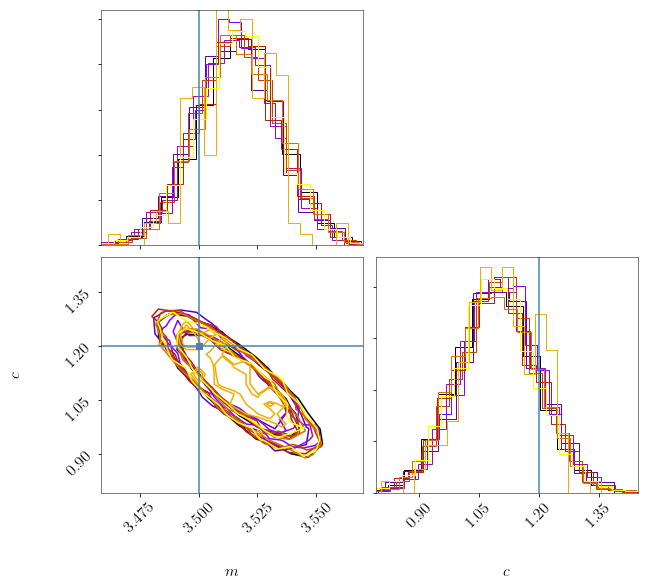

In [54]:
from matplotlib.pyplot import cm 
from matplotlib.colors import to_hex

# get a list of all the samples
chains = [samples_emcee, samples_pymc3, samples_pystan, samples_pyjags, samples_nestle, samples_cpnest,
          samples_pymnest, samples_dnest4, samples_polychord]

color = cm.gnuplot(np.linspace(0, 1, len(chains)))

hist2dkwargs = {'plot_datapoints': False,
                'plot_density': False,
                'levels': 1.0 - np.exp(-0.5 * np.arange(1.5, 2.1, 0.5) ** 2)} # roughly 1 and 2 sigma

for i, chain in enumerate(chains):
    cv = to_hex(color[i])
    if i == 0:
        fig = corner.corner(chain, labels=[r"$m$", r"$c$"], color=cv, hist_kwargs={'normed': True}, **hist2dkwargs)
    else:
        if i < len(chains)-1:
            corner.corner(chain, labels=[r"$m$", r"$c$"], fig=fig, color=cv, hist_kwargs={'normed': True}, **hist2dkwargs)
        else: # plot true values on last plot
            corner.corner(chain, labels=[r"$m$", r"$c$"], truths=[m, c], fig=fig, color=cv, hist_kwargs={'normed': True}, **hist2dkwargs)
            
fig.set_size_inches(10.0, 9.0)

In [55]:
from IPython.display import Markdown

outputtable = six.u("""
| Sampler | $m$ | $c$ | corr. coeff |
|--- | :---: | :---: | :---: |
| emcee | {memcee_mu:.3f} \u00B1 {memcee_sig:.3f} | {cemcee_mu:.3f} \u00B1 {cemcee_sig:.3f} | {ccemcee:.3f} |
| PyMC3 | {mpymc3_mu:.3f} \u00B1 {mpymc3_sig:.3f} | {cpymc3_mu:.3f} \u00B1 {cpymc3_sig:.3f} | {ccpymc3:.3f} |
| PyStan | {mpystan_mu:.3f} \u00B1 {mpystan_sig:.3f} | {cpystan_mu:.3f} \u00B1 {cpystan_sig:.3f} | {ccpystan:.3f} |
| PyJAGS | {mpyjags_mu:.3f} \u00B1 {mpyjags_sig:.3f} | {cpyjags_mu:.3f} \u00B1 {cpyjags_sig:.3f} | {ccpyjags:.3f} |
| Nestle | {mnestle_mu:.3f} \u00B1 {mnestle_sig:.3f} | {cnestle_mu:.3f} \u00B1 {cnestle_sig:.3f} | {ccnestle:.3f} |
| CPNest | {mcpnest_mu:.3f} \u00B1 {mcpnest_sig:.3f} | {ccpnest_mu:.3f} \u00B1 {ccpnest_sig:.3f} | {cccpnest:.3f} |
| PyMultiNest | {mpymnest_mu:.3f} \u00B1 {mpymnest_sig:.3f} | {cpymnest_mu:.3f} \u00B1 {cpymnest_sig:.3f} | {ccpymnest:.3f} |
| DNest4 | {mdnest4_mu:.3f} \u00B1 {mdnest4_sig:.3f} | {cdnest4_mu:.3f} \u00B1 {cdnest4_sig:.3f} | {ccdnest4:.3f} |
| PyPolyChord | {mpolychord_mu:.3f} \u00B1 {mpolychord_sig:.3f} | {cpolychord_mu:.3f} \u00B1 {cpolychord_sig:.3f} | {ccpolychord:.3f} |
""")

Markdown(outputtable.format(**resdict))


| Sampler | $m$ | $c$ | corr. coeff |
|--- | :---: | :---: | :---: |
| emcee | 3.517 ± 0.018 | 1.093 ± 0.100 | -0.858 |
| PyMC3 | 3.515 ± 0.018 | 1.104 ± 0.103 | -0.871 |
| PyStan | 3.516 ± 0.017 | 1.103 ± 0.095 | -0.854 |
| PyJAGS | 3.515 ± 0.017 | 1.104 ± 0.099 | -0.853 |
| Nestle | 3.516 ± 0.018 | 1.096 ± 0.101 | -0.865 |
| CPNest | 3.516 ± 0.017 | 1.097 ± 0.098 | -0.862 |
| PyMultiNest | 3.517 ± 0.018 | 1.093 ± 0.100 | -0.865 |
| DNest4 | 3.515 ± 0.016 | 1.104 ± 0.093 | -0.839 |
| PyPolyChord | 3.517 ± 0.017 | 1.093 ± 0.100 | -0.863 |


In [56]:
outputnest = six.u("""
#### Nested sampling

| Sampler | $\ln{{Z}}$ | num. posterior samples | run time (s) |
| --- | --- | :---: | --- |
| Nestle | {nestle_logZ:.3f} \u00B1 {nestle_logZerr:.3f} | {nestle_npos} | {nestle_time:.3f} |
| CPNest | {cpnest_logZ:.3f} \u00B1 {cpnest_logZerr:.3f} | {cpnest_npos} | {cpnest_time:.3f} |
| PyMultiNest | {pymnest_logZ:.3f} \u00B1 {pymnest_logZerr:.3f} | {pymnest_npos} | {pymnest_time:.3f} |
| DNest4 | {dnest4_logZ:.3f} | {dnest4_npos} | {dnest4_time:.3f} |
| PyPolyChord| {polychord_logZ:.3f} \u00B1 {polychord_logZerr:.3f} | {polychord_npos} | {polychord_time:.3f} |
""")

Markdown(outputnest.format(**resdict))


#### Nested sampling

| Sampler | $\ln{Z}$ | num. posterior samples | run time (s) |
| --- | --- | :---: | --- |
| Nestle | -87.895 ± 0.102 | 2444 | 1.358 |
| CPNest | -87.638 ± 0.101 | 2733 | 17.549 |
| PyMultiNest | -87.770 ± 0.101 | 3588 | 4.927 |
| DNest4 | -95.983 | 157 | 296.009 |
| PyPolyChord| -87.919 ± 0.102 | 2605 | 8.609 |


## Running this notebook

I have created a [Docker image](https://hub.docker.com/r/mattpitkin/samplers/tags/), available on [Docker Hub](https://hub.docker.com/), in which all the above samplers are installed, and that can be used to run this notebook in [Jupyter](http://jupyter.org/). You can download this notebook from [here](http://mattpitkin.github.io/samplers-demo/downloads/notebooks/Samplers.ipynb).

If you have Docker installed you can then run the notebook with:

```bash
docker run -it -v {notebook_location}:/home/jovyan/work -e NB_UID=1001 --user root --rm -p 8888:8888 mattpitkin/samplers:jupyter
```

where `{notebook_location}` is replaced with the path containing the downloaded notebook. This will provide a link that can be pasted into your browser to show the notebook, and the `Samplers.ipynb` file can be selected. By default the notebook will open with a Python 3 kernel, but it can be switched to a Python 2 kernel.